<a href="https://colab.research.google.com/github/sheltonmaharesh/Projects/blob/main/Bot_Flagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

## Business Context

A bot has been detected in our ad click traffic. We are analyzing a dataset of approximately **15,000 URLs** that includes both **legitimate user clicks and fraudulent bot clicks**. The goal is to detect and understand **anomalous behavior** within this dataset.

Each record includes:

- **Timestamp of the event**
- **Server region**
- **Generalized device information**
- A parameter string with details such as:
  - **Ad clicked** (`d=`)
  - **Time to click** (`ttc`)
  - **Original search terms** (`q=`)

The data is based on a **real bot incident** with at least **1% of events confirmed fraudulent**. While some fields are anonymized or substituted, consistent substitutions maintain behavioral integrity (e.g., “android” always refers to the same original term).

This project aims to **identify and explain click fraud**, **recommend filtering strategies**, and **present results in a format accessible to business users**.


### Objective

The primary objective of this project is to **detect and characterize fraudulent ad click activity caused by bots** in a dataset of approximately **15,000 URLs** representing a mix of legitimate and fraudulent traffic. Specifically, the goals are to:

1. **Develop an anomaly detection classifier** capable of distinguishing between legitimate user interactions and bot-generated traffic.
2. **Explain and justify the detection logic** with data-driven evidence and propose filters for similar future datasets.
3. **Communicate findings through visualizations** suitable for business stakeholders without technical backgrounds.
4. **Evaluate generalizability and limitations** of the approach on other datasets.
5. **Assess the precision and probability** of fraud detection for individual flagged events.
6. **Recommend action strategies** based on detection probabilities and practical business constraints.
7. **Outline future improvements** assuming more time and resources are available.


## Data Loading

In [29]:
# uncomment and run the following line if using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Load the TSV file
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Trainings/Projects/DuckDuckGo/Round_2/bot-hunter-dataset.tsv", sep="\t")

In [31]:
df.head()

,2019-12-02 18:52:42,Earth,Edge,Android,/ad_click?n=1&f=1&d=www.amazon.ca&sld=0&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=5314&q=sh%20rug%20gasmaker%20matty&ct=CA&kl=wt-wt&kp=-1,Unnamed: 5
0,2019-12-02 16:30:07,Earth,Edge,Android,/ad_click?n=1&f=1&d=regus.ca&sld=0&st=mobile_s...,NaN
1,2019-12-02 13:04:19,Mars,Safari,Android,/ad_click?n=1&f=1&d=www.heathrowexpress.com&sl...,NaN
2,2019-12-02 07:35:56,Mars,Chrome,Android,/ad_click?n=1&f=1&d=www.heathrowexpress.com&sl...,NaN
3,2019-12-02 08:59:14,Earth,Chrome,Android,/ad_click?n=1&f=1&d=www.greyhound.com&sld=0&st...,NaN
4,2019-12-02 13:49:38,Mars,Chrome,Android,/ad_click?n=1&f=1&d=free.messianicbible.com&sl...,NaN


## Data Preprocessing

In [32]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse, parse_qs
from sklearn.preprocessing import LabelEncoder


# Ensure expected number of columns
expected_cols = ['timestamp', 'region', 'browser', 'device', 'd']
if df.shape[1] >= len(expected_cols):
    df = df.iloc[:, :len(expected_cols)]
    df.columns = expected_cols
else:
    raise ValueError(f"Unexpected number of columns: {df.shape[1]} (expected at least {len(expected_cols)})")

# -------------------------------
# Parse URL query parameters from 'd'
# -------------------------------
def parse_url_params(url):
    if pd.isna(url):
        return {}
    try:
        query = urlparse(url).query
        return {k: v[0] if isinstance(v, list) and len(v) == 1 else v for k, v in parse_qs(query).items()}
    except Exception:
        return {}

parsed_params = df['d'].apply(parse_url_params)
param_df = pd.json_normalize(parsed_params)

# -------------------------------
# Combine original and parsed columns
# -------------------------------
df_clean = pd.concat([df, param_df], axis=1)

# -------------------------------
# Data Cleaning
# -------------------------------
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], errors='coerce')

if 'ttc' in df_clean.columns:
    df_clean['ttc'] = pd.to_numeric(df_clean['ttc'], errors='coerce')
    df_clean['ttc'] = df_clean['ttc'].fillna(df_clean['ttc'].median())

# Fill missing string values with "unknown"
for col in df_clean.select_dtypes(include='object').columns:
    df_clean[col] = df_clean[col].fillna("unknown")

# -------------------------------
# Prepare Features for ML
# -------------------------------
features = df_clean.drop(columns=['timestamp'], errors='ignore').copy()

# Drop problematic columns
bad_cols = [col for col in features.columns if features[col].apply(lambda x: isinstance(x, (list, dict, pd.Series, pd.DataFrame))).any()]
features.drop(columns=bad_cols, inplace=True)

# Encode categorical features
encoders = {}
for col in features.select_dtypes(include='object').columns:
    try:
        le = LabelEncoder()
        features[col] = le.fit_transform(features[col].astype(str))
        encoders[col] = le
    except Exception as e:
        print(f"Skipping column '{col}' due to encoding error: {e}")
        features.drop(columns=[col], inplace=True)

# -------------------------------
# Result: Clean Feature Set
# -------------------------------
print("✅ Features ready for modeling:")
print(features.head())


✅ Features ready for modeling:
   region  browser  device  n  f  sld  st  nt  r  adx  ...   ct  kl  kp  \
0       0        2       0  0  0    0   0   0  0    1  ...   25  24   0   
1       2        3       0  0  0    1   0   0  0    1  ...  131  18   0   
2       2        1       0  0  0    1   0   0  0    1  ...   49  24   1   
3       0        1       0  0  0    0   0   0  0    1  ...   25  24   0   
4       2        1       0  0  0    0   0   0  0    1  ...   49  24   0   

   lsexp1  bkl  om  atb  va  atbva  atbexp  
0       2   46   2    1   3      7       1  
1       2   46   2    1   3      7       1  
2       2   46   2    1   3      7       1  
3       2   46   2    1   3      7       1  
4       2   46   2    1   3      7       1  

[5 rows x 23 columns]


## Anamology detection using SVM and Isolation forest

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import joblib
import itertools

# -------------------------------
# Step 7: Normalize features
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Save the scaler for inference
joblib.dump(scaler, "scaler.joblib")

# -------------------------------
# Step 8: Isolation Forest Tuning
# -------------------------------
iso_param_grid = {
    'n_estimators': [100],
    'contamination': [0.01, 0.02, 0.05],
    'max_samples': ['auto', 0.5],
    'max_features': [1.0, 0.8]
}

best_if_model = None
best_if_score = -1

for params in itertools.product(*iso_param_grid.values()):
    param_dict = dict(zip(iso_param_grid.keys(), params))
    model = IsolationForest(**param_dict, random_state=42)
    preds = model.fit_predict(X_scaled)
    labels = np.where(preds == 1, 0, 1)  # 1: normal, -1: anomaly → 0: legit, 1: bot
    if len(np.unique(labels)) == 2:
        score = silhouette_score(X_scaled, labels)
        if score > best_if_score:
            best_if_score = score
            best_if_model = model

# Apply model and generate anomaly probabilities
iso_scores = best_if_model.decision_function(X_scaled).reshape(-1, 1)
iso_scaler = MinMaxScaler()
iso_probs = 1 - iso_scaler.fit_transform(iso_scores)

df_clean['isolation_forest_bot'] = (best_if_model.predict(X_scaled) == -1).astype(int)
df_clean['iso_anomaly_prob'] = iso_probs


# -------------------------------
# Step 9: One-Class SVM Tuning
# -------------------------------
svm_param_grid = {
    'kernel': ['rbf'],
    'gamma': ['scale', 0.1],
    'nu': [0.01, 0.02, 0.05]
}

best_svm_model = None
best_svm_score = -1

for params in itertools.product(*svm_param_grid.values()):
    param_dict = dict(zip(svm_param_grid.keys(), params))
    model = OneClassSVM(**param_dict)
    preds = model.fit_predict(X_scaled)
    labels = np.where(preds == 1, 0, 1)
    if len(np.unique(labels)) == 2:
        score = silhouette_score(X_scaled, labels)
        if score > best_svm_score:
            best_svm_score = score
            best_svm_model = model

# Apply model and generate anomaly probabilities
svm_scores = best_svm_model.decision_function(X_scaled).reshape(-1, 1)
svm_scaler = MinMaxScaler()
svm_probs = 1 - svm_scaler.fit_transform(svm_scores)

df_clean['svm_bot'] = (best_svm_model.predict(X_scaled) == -1).astype(int)
df_clean['svm_anomaly_prob'] = svm_probs

# -------------------------------
# Step 10: Output Preview
# -------------------------------

df_full = pd.concat([features.reset_index(drop=True),
                     df_clean[['timestamp',
                               'isolation_forest_bot', 'iso_anomaly_prob',
                               'svm_bot', 'svm_anomaly_prob']].reset_index(drop=True)], axis=1)

print(df_full.head(10))


   region  browser  device  n  f  sld  st  nt  r  adx  ...  om  atb  va  \
0       0        2       0  0  0    0   0   0  0    1  ...   2    1   3   
1       2        3       0  0  0    1   0   0  0    1  ...   2    1   3   
2       2        1       0  0  0    1   0   0  0    1  ...   2    1   3   
3       0        1       0  0  0    0   0   0  0    1  ...   2    1   3   
4       2        1       0  0  0    0   0   0  0    1  ...   2    1   3   
5       2        1       0  0  0    1   0   0  0    1  ...   2    1   3   
6       2        1       0  0  0    0   0   0  0    1  ...   2    1   3   
7       2        2       0  0  0    0   0   0  0    1  ...   2    1   3   
8       2        2       0  0  0    0   0   0  0    1  ...   2    1   3   
9       2        2       0  0  0    0   0   0  0    1  ...   2    1   3   

   atbva  atbexp           timestamp  isolation_forest_bot  iso_anomaly_prob  \
0      7       1 2019-12-02 16:30:07                     0          0.037241   
1      7      

## Outcome of SVM and Isolation forest

In [34]:
# Count anomaly vs normal from Isolation Forest
iso_counts = df_clean['isolation_forest_bot'].value_counts().rename(index={0: 'Normal', 1: 'Anomalous'})
print("Isolation Forest - Anomaly Counts:\n", iso_counts)

Isolation Forest - Anomaly Counts:
 isolation_forest_bot
Normal       15469
Anomalous      157
Name: count, dtype: int64


In [35]:
# Count anomaly vs normal from SVM
svm_counts = df_clean['svm_bot'].value_counts().rename(index={0: 'Normal', 1: 'Anomalous'})
print("One-Class SVM - Anomaly Counts:\n", svm_counts)

One-Class SVM - Anomaly Counts:
 svm_bot
Normal       15438
Anomalous      188
Name: count, dtype: int64


## Exploratory Data Analysis

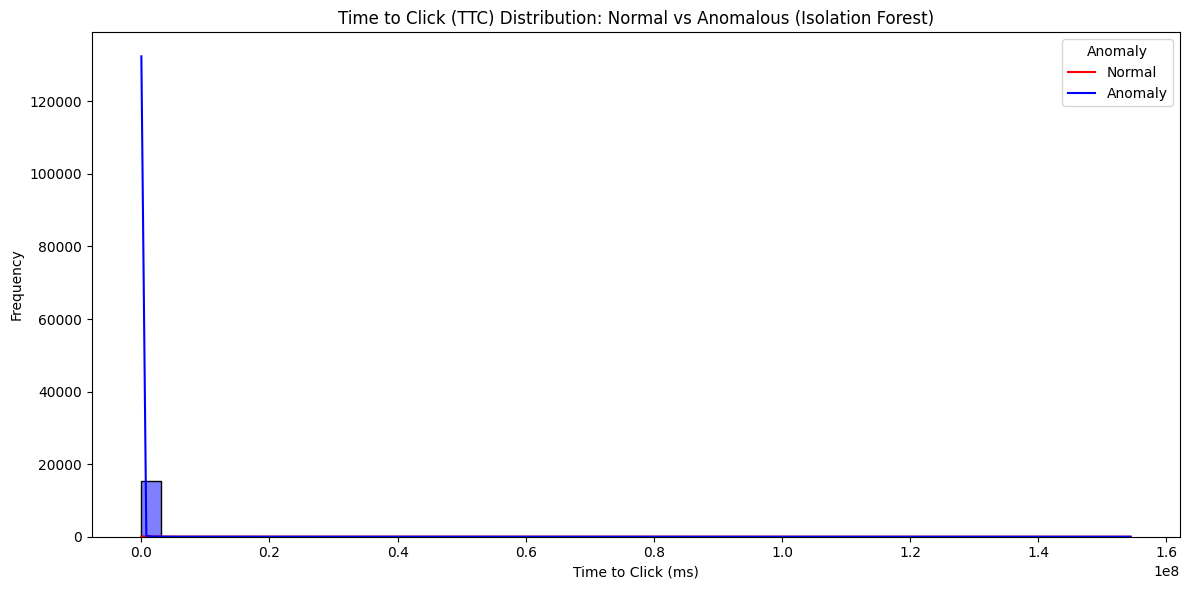

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_clean,
    x='ttc',
    hue='isolation_forest_bot',
    bins=50,
    kde=True,
    palette={0: 'blue', 1: 'red'}
)
plt.title("Time to Click (TTC) Distribution: Normal vs Anomalous (Isolation Forest)")
plt.xlabel("Time to Click (ms)")
plt.ylabel("Frequency")
plt.legend(title="Anomaly", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.savefig("ttc_anomaly_distribution.png")
plt.show()

In [37]:
# Mean TTC for anomalous clicks
anomaly_mean_ttc = df_clean[df_clean['isolation_forest_bot'] == 1]['ttc'].mean()

# Mean TTC for all clicks
overall_mean_ttc = df_clean['ttc'].mean()

# Print results in milliseconds and minutes
print("Mean TTC (Anomalous):", round(anomaly_mean_ttc, 2), "ms →", round(anomaly_mean_ttc / 60000, 2), "minutes")
print("Mean TTC (Overall):", round(overall_mean_ttc, 2), "ms →", round(overall_mean_ttc / 60000, 2), "minutes")


Mean TTC (Anomalous): 2028604.46 ms → 33.81 minutes
Mean TTC (Overall): 64383.84 ms → 1.07 minutes


In [38]:
anomaly_median_ttc = df_clean[df_clean['isolation_forest_bot'] == 1]['ttc'].median()
overall_median_ttc = df_clean['ttc'].median()

print("Median TTC (Anomalous):", anomaly_median_ttc, "ms →", round(anomaly_median_ttc / 60000, 2), "minutes")
print("Median TTC (Overall):", overall_median_ttc, "ms →", round(overall_median_ttc / 60000, 2), "minutes")

Median TTC (Anomalous): 8265.0 ms → 0.14 minutes
Median TTC (Overall): 7058.0 ms → 0.12 minutes


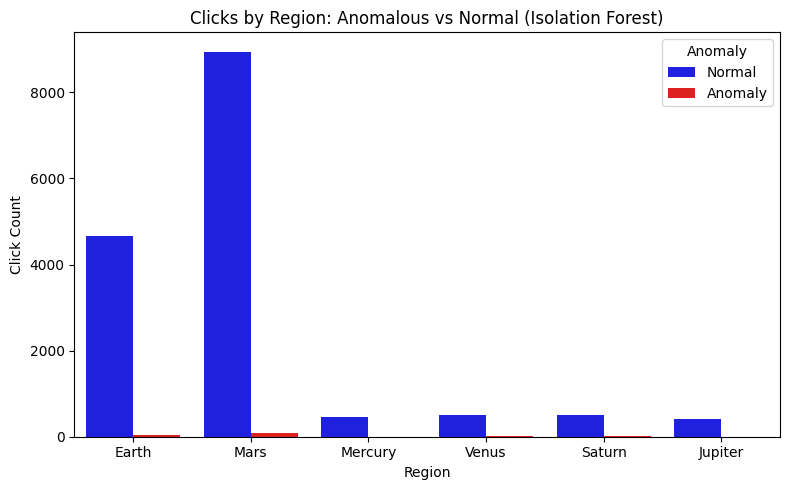

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clean, x='region', hue='isolation_forest_bot', palette={0: 'blue', 1: 'red'})
plt.title("Clicks by Region: Anomalous vs Normal (Isolation Forest)")
plt.xlabel("Region")
plt.ylabel("Click Count")
plt.legend(title="Anomaly", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.savefig("region_anomaly_comparison.png")
plt.show()

/tmp/ipython-input-40-3578108335.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottom[i] + val / 2,


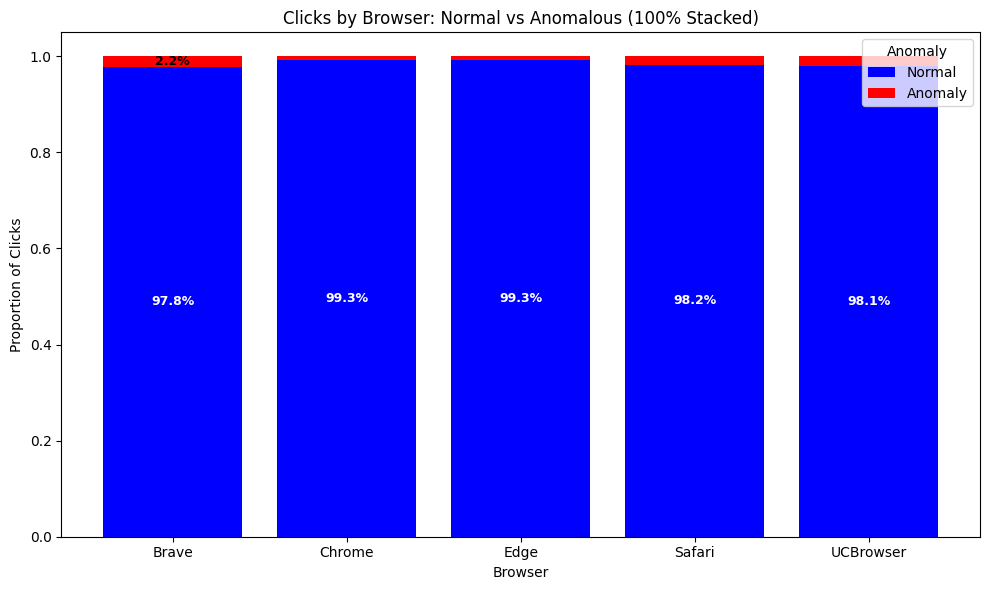

In [40]:
import matplotlib.pyplot as plt

# Step 1: Group and pivot
browser_counts = df_clean.groupby(['browser', 'isolation_forest_bot']).size().unstack(fill_value=0)

# Step 2: Convert to percentages
browser_props = browser_counts.div(browser_counts.sum(axis=1), axis=0)

# Step 3: Plot
fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(browser_props))

colors = {0: 'blue', 1: 'red'}
labels = {0: "Normal", 1: "Anomaly"}

for col in browser_props.columns:
    ax.bar(browser_props.index, browser_props[col], bottom=bottom, label=labels[col], color=colors[col])

    # Add percentage labels
    for i, val in enumerate(browser_props[col]):
        if val > 0.02:
            ax.text(
                i,
                bottom[i] + val / 2,
                f"{val * 100:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if val > 0.3 else 'black',
                fontweight='bold'
            )
    bottom += browser_props[col]

# Step 4: Final plot
ax.set_title("Clicks by Browser: Normal vs Anomalous (100% Stacked)")
ax.set_xlabel("Browser")
ax.set_ylabel("Proportion of Clicks")
ax.legend(title="Anomaly", loc='upper right')
plt.tight_layout()
plt.savefig("100pct_stacked_browser_anomaly_labeled.png")
plt.show()


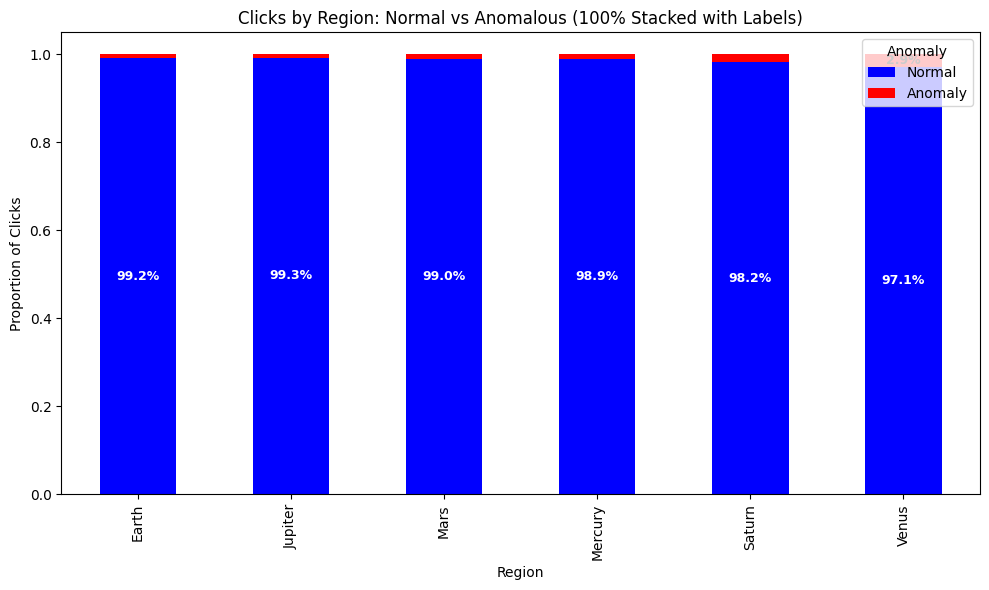

In [41]:
import matplotlib.pyplot as plt

# Step 1: Group and pivot
region_counts = df_clean.groupby(['region', 'isolation_forest_bot']).size().unstack(fill_value=0)

# Step 2: Convert to 100% proportions
region_props = region_counts.div(region_counts.sum(axis=1), axis=0)

# Step 3: Plot
ax = region_props.plot(
    kind='bar',
    stacked=True,
    color=['blue', 'red'],
    figsize=(10, 6)
)

# Step 4: Annotate each segment with percentage
for i, region in enumerate(region_props.index):
    bottom = 0
    for j, col in enumerate(region_props.columns):
        value = region_props.loc[region, col]
        if value > 0.02:  # avoid cluttering small values
            ax.text(
                i,
                bottom + value / 2,
                f"{value*100:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if value > 0.25 else 'black',
                fontweight='bold'
            )
        bottom += value

# Step 5: Customize and save
plt.title("Clicks by Region: Normal vs Anomalous (100% Stacked with Labels)")
plt.xlabel("Region")
plt.ylabel("Proportion of Clicks")
plt.legend(title="Anomaly", labels=["Normal", "Anomaly"], loc='upper right')
plt.tight_layout()
plt.savefig("100pct_stacked_region_anomaly_labeled.png")
plt.show()


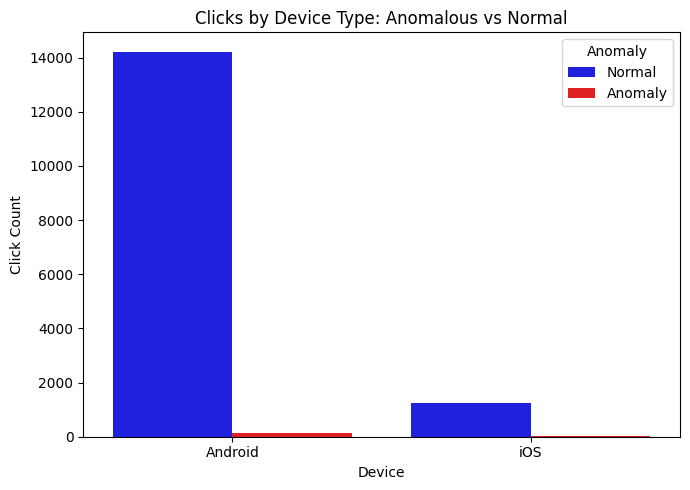

In [42]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df_clean, x='device', hue='isolation_forest_bot', palette={0: 'blue', 1: 'red'})
plt.title("Clicks by Device Type: Anomalous vs Normal")
plt.xlabel("Device")
plt.ylabel("Click Count")
plt.legend(title="Anomaly", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.savefig("device_anomaly_comparison.png")
plt.show()

/tmp/ipython-input-43-243869122.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottom[i] + val / 2,


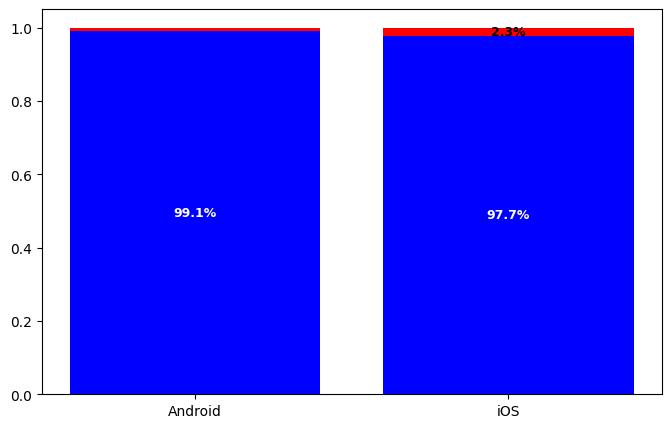

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Group and normalize
device_counts = df_clean.groupby(['device', 'isolation_forest_bot']).size().unstack(fill_value=0)
device_props = device_counts.div(device_counts.sum(axis=1), axis=0)

# Step 2: Plot
fig, ax = plt.subplots(figsize=(8, 5))
bottom = np.zeros(len(device_props))
colors = {0: 'blue', 1: 'red'}
labels = {0: "Normal", 1: "Anomaly"}

for col in device_props.columns:
    ax.bar(device_props.index, device_props[col], bottom=bottom, color=colors[col], label=labels[col])

    # Add percentage labels
    for i, val in enumerate(device_props[col]):
        if val > 0.02:
            ax.text(
                i,
                bottom[i] + val / 2,
                f"{val * 100:.1f}%",
                ha='center',
                va='center',
                fontsize=9,
                color='white' if val > 0.3 else 'black',
                fontweight='bold'
            )
    bottom += device_props[col]

In [44]:
df_clean

,timestamp,region,browser,device,d,n,f,d,sld,st,...,bkl,om,atb,va,atbva,atbexp,isolation_forest_bot,iso_anomaly_prob,svm_bot,svm_anomaly_prob
0,2019-12-02 16:30:07,Earth,Edge,Android,/ad_click?n=1&f=1&d=regus.ca&sld=0&st=mobile_s...,1,1,regus.ca,0,mobile_search_intl,...,unknown,unknown,unknown,unknown,unknown,unknown,0,0.037241,0,0.338798
1,2019-12-02 13:04:19,Mars,Safari,Android,/ad_click?n=1&f=1&d=www.heathrowexpress.com&sl...,1,1,www.heathrowexpress.com,1,mobile_search_intl,...,unknown,unknown,unknown,unknown,unknown,unknown,0,0.189086,0,0.401484
2,2019-12-02 07:35:56,Mars,Chrome,Android,/ad_click?n=1&f=1&d=www.heathrowexpress.com&sl...,1,1,www.heathrowexpress.com,1,mobile_search_intl,...,unknown,unknown,unknown,unknown,unknown,unknown,0,0.111215,0,0.302062
3,2019-12-02 08:59:14,Earth,Chrome,Android,/ad_click?n=1&f=1&d=www.greyhound.com&sld=0&st...,1,1,www.greyhound.com,0,mobile_search_intl,...,unknown,unknown,unknown,unknown,unknown,unknown,0,0.033187,0,0.413119
4,2019-12-02 13:49:38,Mars,Chrome,Android,/ad_click?n=1&f=1&d=free.messianicbible.com&sl...,1,1,free.messianicbible.com,0,mobile_search_intl,...,unknown,unknown,unknown,unknown,unknown,unknown,0,0.065242,0,0.345972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,2019-12-02 07:08:28,Mercury,Edge,Android,/ad_click?n=1&f=1&d=hk.trip.com&sld=1&st=mobil...,1,1,hk.trip.com,1,mobile_search_intl,...,ra-0,unknown,unknown,unknown,unknown,unknown,0,0.161759,0,0.221748
15622,2019-12-02 07:07:42,Mercury,Edge,Android,/ad_click?n=1&f=1&d=hk.trip.com&sld=1&st=mobil...,1,1,hk.trip.com,1,mobile_search_intl,...,unknown,unknown,unknown,unknown,unknown,unknown,0,0.149460,0,0.257534
15623,2019-12-02 15:22:42,Mars,Chrome,Android,/ad_click?n=1&f=1&d=www.amazon.ca&sld=0&st=mob...,1,1,www.amazon.ca,0,mobile_search_intl,...,unknown,unknown,unknown,unknown,unknown,unknown,0,0.037449,0,0.339163
15624,2019-12-02 13:45:42,Mars,Chrome,Android,/ad_click?n=1&f=1&d=www.flicksmore.com&sld=1&s...,1,1,www.flicksmore.com,1,mobile_search_intl,...,unknown,unknown,unknown,unknown,unknown,unknown,0,0.045104,0,0.365349


## Converting it to a supervised learning problem

In [45]:
rf_features = features
rf_features

,region,browser,device,n,f,sld,st,nt,r,adx,...,ct,kl,kp,lsexp1,bkl,om,atb,va,atbva,atbexp
0,0,2,0,0,0,0,0,0,0,1,...,25,24,0,2,46,2,1,3,7,1
1,2,3,0,0,0,1,0,0,0,1,...,131,18,0,2,46,2,1,3,7,1
2,2,1,0,0,0,1,0,0,0,1,...,49,24,1,2,46,2,1,3,7,1
3,0,1,0,0,0,0,0,0,0,1,...,25,24,0,2,46,2,1,3,7,1
4,2,1,0,0,0,0,0,0,0,1,...,49,24,0,2,46,2,1,3,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15621,3,2,0,0,0,1,0,0,0,1,...,58,10,0,2,41,2,1,3,7,1
15622,3,2,0,0,0,1,0,0,0,1,...,58,10,0,2,46,2,1,3,7,1
15623,2,1,0,0,0,0,0,0,0,1,...,25,24,0,2,46,2,1,3,7,1
15624,2,1,0,0,0,1,0,0,0,1,...,49,24,0,2,46,2,1,3,7,1


In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define features and pseudo-labels
rf_features = features.copy()  # Already includes region, browser, device, ttc, d, q, ct
#rf_features['iso_anomaly_prob'] = df_clean['iso_anomaly_prob']
#rf_features['svm_anomaly_prob'] = df_clean['svm_anomaly_prob']
rf_labels = ((df_clean['isolation_forest_bot'] + df_clean['svm_bot']) >= 1).astype(int)  # Label = 1 if detected by either

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(rf_features, rf_labels, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4613
           1       0.92      0.15      0.25        75

    accuracy                           0.99      4688
   macro avg       0.95      0.57      0.62      4688
weighted avg       0.99      0.99      0.98      4688

Confusion Matrix:
[[4612    1]
 [  64   11]]
ROC-AUC Score: 0.9756138449309921


In [67]:
(rf_labels == 1).sum()

np.int64(254)

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances and match them with column names
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df)

             Feature  Importance
24  svm_anomaly_prob    0.440456
23  iso_anomaly_prob    0.354901
4                  f    0.051297
21             atbva    0.038708
8                  r    0.022245
19               atb    0.017210
11               ttc    0.015648
9                adx    0.010097
7                 nt    0.007033
20                va    0.006292
12                 q    0.005594
13                ct    0.005492
22            atbexp    0.005235
15                kp    0.004311
14                kl    0.003424
18                om    0.002641
0             region    0.002469
17               bkl    0.001886
1            browser    0.001856
16            lsexp1    0.000906
2             device    0.000837
5                sld    0.000675
3                  n    0.000465
10          adx_name    0.000320
6                 st    0.000000


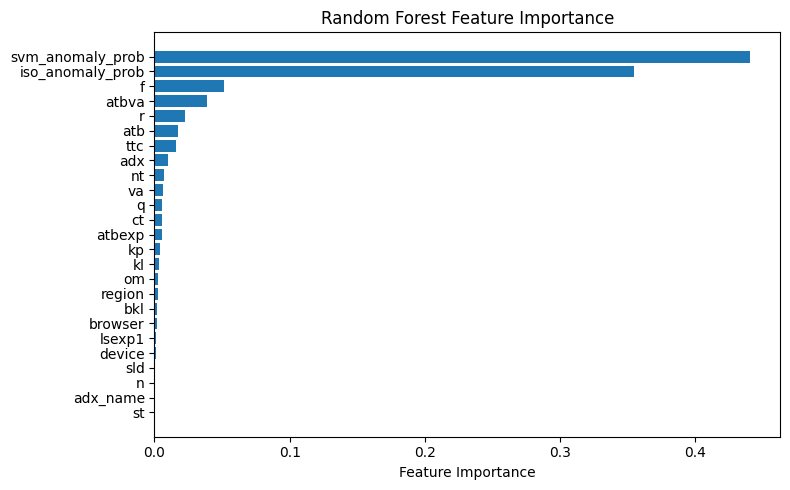

In [48]:
plt.figure(figsize=(8, 5))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [49]:
# to interpret the model results
import shap
shap.initjs()
# Explain the training data using shap
explainer = shap.TreeExplainer(rf_model)

# Calculating the SHAP values for the training and testing data
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

In [50]:
print("SHAP .values shape for training set:", shap_values_train.values.shape)
print("SHAP .values shape for the test set:", shap_values_test.values.shape)

SHAP .values shape for training set: (10938, 25, 2)
SHAP .values shape for the test set: (4688, 25, 2)


In [51]:
print("SHAP shape:", shap_values_train.values.shape)
print("Base values shape:", shap_values_train.base_values.shape)
print("Model outputs:", getattr(shap_values_train, 'model_output_names', 'Not available'))


SHAP shape: (10938, 25, 2)
Base values shape: (10938, 2)
Model outputs: Not available


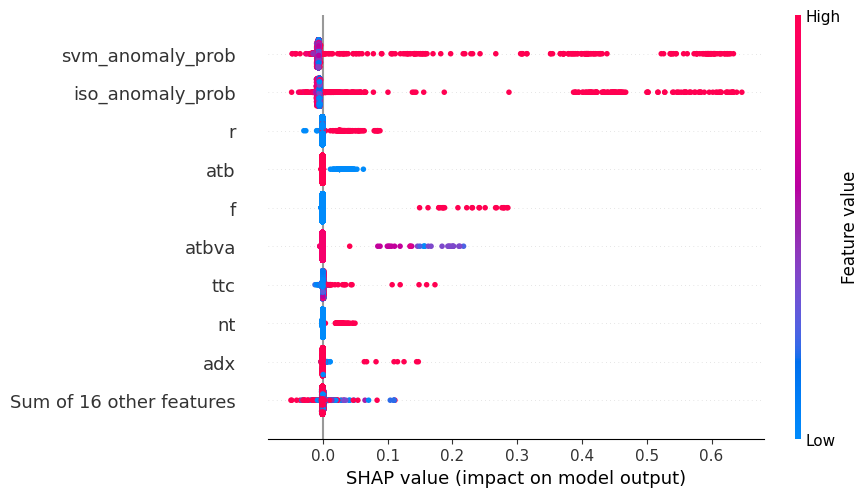

In [52]:
shap.plots.beeswarm(shap_values_train[:, :, 1], show=True)

In [53]:
print("\nDecoded example:")
for col in encoders:
    encoded_val = features[col].iloc[0]  # pick any row (e.g., 0)
    try:
        original_val = encoders[col].inverse_transform([encoded_val])[0]
        print(f"{col}: {encoded_val} -> {original_val}")
    except Exception as e:
        print(f"{col}: {encoded_val} -> [error decoding: {e}]")



Decoded example:
region: 0 -> Earth
browser: 2 -> Edge
device: 0 -> Android
n: 0 -> 1
f: 0 -> 1
sld: 0 -> 0
st: 0 -> mobile_search_intl
nt: 0 -> 0
r: 0 -> 0
adx: 1 -> none
adx_name: 1 -> none
q: 7690 -> poky gloze bedikah gangliac
ct: 25 -> CA
kl: 24 -> wt-wt
kp: 0 -> -1
lsexp1: 2 -> unknown
bkl: 46 -> unknown
om: 2 -> unknown
atb: 1 -> unknown
va: 3 -> unknown
atbva: 7 -> unknown
atbexp: 1 -> unknown


In [54]:
i = 2079
class_idx = 1

# Get SHAP values and base value for this class
shap_vals = shap_values_test.values[i, :, class_idx]
base_val = shap_values_test.base_values[i, class_idx]
x_vals = X_test.iloc[i]
feature_names = X_test.columns

print(f"\n📊 SHAP Contributions for Instance {i}, Class {class_idx} (with decoded feature values):\n")

for col, sval in zip(feature_names, shap_vals):
    encoded_val = x_vals[col]

    # Try decoding
    try:
        if col in encoders:
            decoded_val = encoders[col].inverse_transform([int(encoded_val)])[0]
        else:
            decoded_val = encoded_val
    except Exception as e:
        decoded_val = encoded_val  # fallback to raw

    # Determine SHAP direction
    direction = "↑" if sval > 0 else "↓" if sval < 0 else "→"

    print(f"{col:20}: {str(decoded_val):<25} | SHAP = {sval:+.4f} {direction}")

final_pred_val = base_val + shap_vals.sum()
print(f"\nModel base value for class {class_idx}: {base_val:.4f}")
print(f"Final model output (log-odds or raw score): {final_pred_val:.4f}")



📊 SHAP Contributions for Instance 2079, Class 1 (with decoded feature values):

region              : Earth                     | SHAP = -0.0004 ↓
browser             : Edge                      | SHAP = +0.0008 ↑
device              : Android                   | SHAP = -0.0006 ↓
n                   : 1                         | SHAP = -0.0000 ↓
f                   : 1                         | SHAP = -0.0004 ↓
sld                 : 0                         | SHAP = +0.0000 ↑
st                  : mobile_search_intl        | SHAP = +0.0000 →
nt                  : 0                         | SHAP = -0.0005 ↓
r                   : 0                         | SHAP = -0.0007 ↓
adx                 : none                      | SHAP = -0.0001 ↓
adx_name            : none                      | SHAP = -0.0000 ↓
ttc                 : 14960083.0                | SHAP = +0.1719 ↑
q                   : leto degeneration         | SHAP = +0.0026 ↑
ct                  : CL                        

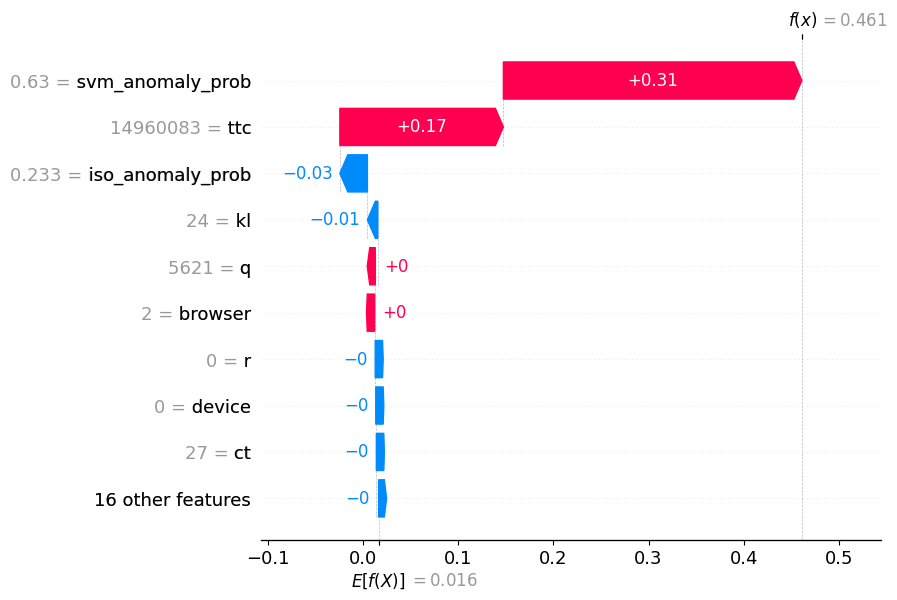

In [55]:
# Waterfall plot for the instance present in test set at index 5
shap.plots.waterfall(shap_values_test[i][:, 1])

In [56]:
import numpy as np

def generate_shap_bot_attack_paragraph(index, shap_values, X, encoders=None, class_index=1, top_n=10):
    shap_vals = shap_values.values[index, :, class_index]
    base_val = shap_values.base_values[index, class_index]
    x_vals = X.iloc[index]
    feature_names = X.columns

    # Decode encoded values
    decoded_vals = {}
    for col in feature_names:
        val = x_vals[col]
        try:
            if encoders and col in encoders:
                decoded_vals[col] = encoders[col].inverse_transform([int(val)])[0]
            else:
                decoded_vals[col] = val
        except:
            decoded_vals[col] = val

    # Sort features by absolute SHAP impact
    feature_contribs = list(zip(feature_names, decoded_vals.values(), shap_vals))
    feature_contribs = sorted(feature_contribs, key=lambda x: abs(x[2]), reverse=True)[:top_n]

    # Separate positive and negative impacts
    positive_impacts = []
    negative_impacts = []

    for fname, fval, sval in feature_contribs:
        line = f"  - {fname:20} = {str(fval):<20} contributed {abs(sval):.4f}"
        if sval > 0:
            positive_impacts.append(line)
        elif sval < 0:
            negative_impacts.append(line)

    final_pred_val = base_val + np.sum(shap_vals)

    print(f"\n==== SHAP Explanation for Instance {index}: Bot Attack Classification ====\n")
    print(f"Base model prediction for class 1 (Bot Attack): {base_val:.2f}")
    print(f"Final model output for this instance        : {final_pred_val:.2f}\n")

    if positive_impacts:
        print("🔺 Factors that INCREASED the likelihood of Bot Attack:")
        print("\n".join(positive_impacts))
        print()

    if negative_impacts:
        print("🔻 Factors that DECREASED the likelihood of Bot Attack:")
        print("\n".join(negative_impacts))
        print()

    print("These features collectively explain the model's classification of this session.\n")


In [64]:
generate_shap_bot_attack_paragraph(
    index=559,
    #2079,
    shap_values=shap_values_test,
    X=X_test,
    encoders=encoders,
    class_index=1,
    top_n=10
)



==== SHAP Explanation for Instance 559: Bot Attack Classification ====

Base model prediction for class 1 (Bot Attack): 0.02
Final model output for this instance        : 0.93

🔺 Factors that INCREASED the likelihood of Bot Attack:
  - iso_anomaly_prob     = 0.5860782104908691   contributed 0.5569
  - f                    = unknown              contributed 0.2820
  - r                    = 2                    contributed 0.0840
  - ttc                  = 12413.0              contributed 0.0031
  - sld                  = 1                    contributed 0.0018
  - ct                   = GB                   contributed 0.0009
  - lsexp1               = unknown              contributed 0.0007
  - region               = Mars                 contributed 0.0004

🔻 Factors that DECREASED the likelihood of Bot Attack:
  - svm_anomaly_prob     = 0.47907128629895335  contributed 0.0101
  - bkl                  = ra-1                 contributed 0.0021

These features collectively explain the 

In [58]:
import numpy as np
import pandas as pd

# Step 1: Get predicted probabilities
probs = rf_model.predict_proba(X_test)  # shape: (n_samples, 2)

# Step 2: Get probabilities for class 1
probs_class1 = probs[:, 1]

# Step 3: Find indices where class 1 probability is around 0.9
# You can adjust the threshold (e.g., 0.88 to 0.92)
high_confidence_idxs = np.where((probs_class1 >= 0.5))[0]

# Step 4: Show top matches
selected = pd.DataFrame({
    "Index": high_confidence_idxs,
    "Class 1 Prob": probs_class1[high_confidence_idxs]
}).sort_values(by="Class 1 Prob", ascending=False)

print(selected.head(20))


    Index  Class 1 Prob
35   2283      0.985557
60   3476      0.967419
14   1084      0.962898
37   2387      0.939720
50   2862      0.935534
5     559      0.934140
39   2536      0.933302
30   2136      0.932292
67   4085      0.930364
31   2157      0.927860
17   1201      0.926444
52   3011      0.921886
53   3056      0.918897
55   3216      0.915582
3     486      0.908698
32   2187      0.901968
58   3371      0.901764
8     651      0.898369
4     491      0.897129
11    787      0.894780


## Save model elements for production

In [59]:
import joblib
joblib.dump(rf_model, '/content/drive/MyDrive/Trainings/Projects/DuckDuckGo/Round_2/model.joblib')
joblib.dump(encoders,"/content/drive/MyDrive/Trainings/Projects/DuckDuckGo/Round_2/encoders.joblib")
joblib.dump(scaler, "/content/drive/MyDrive/Trainings/Projects/DuckDuckGo/Round_2/scaler.joblib")
joblib.dump(iso_scaler, "/content/drive/MyDrive/Trainings/Projects/DuckDuckGo/Round_2/iso_scaler.joblib")
joblib.dump(svm_scaler, "/content/drive/MyDrive/Trainings/Projects/DuckDuckGo/Round_2/svm_scaler.joblib")
joblib.dump(best_if_model, "/content/drive/MyDrive/Trainings/Projects/DuckDuckGo/Round_2/best_if_model.joblib")
joblib.dump(best_svm_model, "/content/drive/MyDrive/Trainings/Projects/DuckDuckGo/Round_2/best_svm_model.joblib")
joblib.dump(X_train.columns.tolist(), "/content/drive/MyDrive/Trainings/Projects/DuckDuckGo/Round_2/feature_names.joblib")

['/content/drive/MyDrive/Trainings/Projects/DuckDuckGo/Round_2/feature_names.joblib']

In [62]:
type(svm_scaler)

sklearn.preprocessing._data.MinMaxScaler

In [61]:
import shap
print(shap.__version__)


0.48.0
